# Download Data

In [ ]:
!mkdir '/content/drive/MyDrive/Bone-Age-Regression'

mkdir: cannot create directory ‘/content/drive/MyDrive/Bone-Age-Regression’: File exists


In [ ]:
!unzip -q '/content/drive/MyDrive/Bone-Age-Regression/bone-age-regression.zip' -d 'data/'

# Import Package

In [ ]:
from typing import Iterator, List, Union, Tuple, Any
from datetime import datetime

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model, regularizers
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import History

# Dataframe Processing

In [ ]:
df = pd.read_csv('data/train.csv')
df = df.sort_values(by='fileName')[:]
df['gender'] = df['male'].map(lambda x: 1 if x==True else 0)
df = df.drop(['male'], axis=1)
df

,fileName,boneage,gender
3957,10000.png,96,1
10831,10001.png,168,1
132,10002.png,168,1
3494,10003.png,76,0
9580,10004.png,135,1
...,...,...,...
4458,9995.png,94,0
521,9996.png,94,0
5916,9997.png,144,0
1399,9998.png,69,0


In [ ]:
# Split dataframe by gender
df_male = df.where(df['gender'] == 1).dropna()
df_female = df.where(df['gender'] == 0).dropna()

In [ ]:
# Take 2500 observations of each dataframe
df_male_subset = df_male.sample(n=2500)
df_female_subset = df_female.sample(n=2500)

In [ ]:
# Combine dataframes
df = pd.concat([df_male_subset, df_female_subset], axis=0)

# Reading Dataframe

In [ ]:
df = pd.read_csv('drive/MyDrive/Bone-Age-Regression/sampel.csv')

# Callback Initialization

In [ ]:
class CustomSaver(keras.callbacks.Callback):
  def __init__(self, model_name):
    self.model_name = model_name

  def on_epoch_end(self, epoch, logs={}):
    if (epoch+1) % 50 == 0:  # or save after some epoch, each 50-th epoch etc.
      self.model.save("drive/MyDrive/Bone-Age-Regression/{}_{}_epochs.h5".format(self.model_name, epoch+1))
      print("\nModel Saved at {} epochs".format(epoch+1))

from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', save_freq=1)

# Function for Saving Model and History

In [ ]:
def save(model, model_name, version, history, epoch=None, current_epoch=0):
  # cek existing history
  assert epoch != None
  try:
    old_history = pd.read_csv(f'drive/MyDrive/Bone-Age-Regression/hist_{version}_{model_name}_{current_epoch}_model.csv')
    df_history = pd.DataFrame({
      "loss": old_history['loss'].tolist() + history.history["loss"],
      "val_loss": old_history['val_loss'].tolist() + history.history["val_loss"],
      "mean_absolute_error": old_history['mean_absolute_error'].tolist() + history.history["mean_absolute_error"],
      "val_mean_absolute_error": old_history['val_mean_absolute_error'].tolist() + history.history["val_mean_absolute_error"],
    })
  except:
    df_history = pd.DataFrame({
      "loss": history.history["loss"],
      "val_loss": history.history["val_loss"],
      "mean_absolute_error": history.history["mean_absolute_error"],
      "val_mean_absolute_error": history.history["val_mean_absolute_error"],
    })
  df_history.to_csv(f'drive/MyDrive/Bone-Age-Regression/hist_{version}_{model_name}_{epoch+current_epoch}_model.csv')
  print(f'History: {version}_{model_name} Saved!')
  model.save(f"drive/MyDrive/Bone-Age-Regression/{version}_{model_name}_{epoch+current_epoch}_epochs.h5")
  print(f'Model: {version}_{model_name}_{epoch+current_epoch}_epochs Saved!')
  return model, df_history

# Function for Drawing

In [ ]:
def plot_hist(df_hist, model_name, version, gender=None):
  print(df_hist)
  if gender:
    gender = 'Gender'
  else:
    gender = 'Non-Gender'
  data = df_hist.copy()
  data['Epochs'] = 0
  for i in range(len(data["Epochs"])):
    data["Epochs"][i] = i+1
  plt.figure(figsize=(10, 6))
  # data['mean_absolute_error'][:].plot()
  # data['val_mean_absolute_error'][:].plot()
  data.plot.scatter(x="Epochs", y="mean_absolute_error")
  data.plot.scatter(x="Epochs", y="val_mean_absolute_error")
  plt.legend(['mean_absolute_error', 'val_mean_absolute_error'])
  plt.gca().set_ylim([0, 40])
  plt.gca().set_xlim([0, 31])
  plt.grid(True)
  plt.suptitle(f"{model_name} | {gender}")
  plt.xlabel("epochs")
  plt.ylabel("MAE")
  plt.savefig(f'drive/MyDrive/Bone-Age-Regression/plot_hist_{version}_{model_name}_{len(data)}_epochs')
  plt.show()

# NPZ Processing

In [ ]:
!mkdir 'data/npz'

mkdir: cannot create directory ‘data/npz’: File exists


In [ ]:
import numpy as np
import cv2

df_npz = df.copy()
npz_paths = []
dir = 'data/images/'
npz_dir = 'data/npz/'

for i, row in df_npz.iterrows():

  picture_path = dir + row['fileName']
  npz_path = npz_dir + row['fileName'].split('.')[0] + '.npz'
  npz_paths.append(npz_path)

  pic = cv2.imread(picture_path)
  pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
  pic = cv2.resize(pic, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

  gender = row['gender']
  boneage = row['boneage']

  np.savez_compressed(npz_path, pic=pic, gender=gender, boneage=boneage)

df_npz['NPZ_Path'] = npz_paths
df_npz = df_npz.drop(['fileName'], axis=1)
df_npz.head()

,boneage,gender,NPZ_Path
0,132,0,data/npz/9670.npz
1,21,0,data/npz/1454.npz
2,132,0,data/npz/13246.npz
3,120,0,data/npz/3150.npz
4,180,0,data/npz/2658.npz


In [ ]:
df_npz.describe()

,boneage,gender
count,5000.000000,5000.00000
mean,126.950400,0.50000
std,40.881181,0.50005
min,9.000000,0.00000
25%,96.000000,0.00000
50%,132.000000,0.50000
75%,156.000000,1.00000
max,228.000000,1.00000


# Train-Validation-Test Split

In [ ]:
df_train_npz, df_val_npz = train_test_split(df_npz, test_size=1/10, stratify=df_npz['gender'])
df_train_npz, df_test_npz = train_test_split(df_train_npz, test_size=1/9, stratify=df_train_npz['gender'])

In [ ]:
df_train_npz.describe()

,boneage,gender
count,4000.000000,4000.000000
mean,126.752000,0.500000
std,40.751149,0.500063
min,9.000000,0.000000
25%,96.000000,0.000000
50%,132.000000,0.500000
75%,156.000000,1.000000
max,228.000000,1.000000


# 1st Scenario: Model without Gender

## Non-Gender Generator

In [ ]:
def get_Img_y(df):
  X_pic= []
  y = []
  
  for data in df['NPZ_Path']:
    loaded_npz = np.load(data)

    pic = loaded_npz['pic']
    boneage = loaded_npz['boneage']

    X_pic.append(pic)
    y.append(boneage)
  
  X_pic = np.array(X_pic)
  y = np.array(y)

  return X_pic, y

In [ ]:
gen = ImageDataGenerator(rescale=1.0/255)

# image and boneage      
def generator(image, boneage, batch_size=32):
    genX = gen.flow(image, boneage,  batch_size=batch_size, seed=666)
    while True:
        X = genX.next()
        yield X[0], X[1]

In [ ]:
X_train_pic, y_train = get_Img_y(df_train_npz)

X_train_pic.shape, y_train.shape

((4000, 224, 224, 3), (4000,))

In [ ]:
X_val_pic, y_val = get_Img_y(df_val_npz)

X_val_pic.shape, y_val.shape

((500, 224, 224, 3), (500,))

In [ ]:
X_test_pic, y_test = get_Img_y(df_test_npz)

X_test_pic.shape, y_test.shape

((500, 224, 224, 3), (500,))

In [ ]:
ng_train_generator = generator(X_train_pic, y_train)
ng_validation_generator = generator(X_val_pic, y_val)
ng_test_generator = generator(X_test_pic, y_test)

## Model 1: Non-Gender Bone-CNN (NG-B)

In [ ]:
model_name = 'Non-Gender-Bone-CNN'
version = '32-64-128-256-512-2048-2048'

def bone_cnn() -> Sequential:
    model = models.Sequential(name=model_name)
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(512, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(2048, activation="relu"))
    model.add(layers.Dense(2048, activation="relu"))
    model.add(layers.Dense(1))

    return model

In [ ]:
bone_model = bone_cnn()
bone_model.summary(line_length=100)

Model: "Non-Gender-Bone-CNN"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d_20 (Conv2D)                          (None, 222, 222, 32)                    896            
                                                                                                    
 max_pooling2d_20 (MaxPooling2D)             (None, 111, 111, 32)                    0              
                                                                                                    
 conv2d_21 (Conv2D)                          (None, 109, 109, 64)                    18496          
                                                                                                    
 max_pooling2d_21 (MaxPooling2D)             (None, 54, 54, 64)                      0              
                                                              

In [ ]:
learning_rate = 0.001
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
bone_model.compile(loss='mean_absolute_error', metrics=[MeanAbsoluteError()], optimizer = adam)

In [ ]:
batch_size = 32
epochs = 30

train_size = len(X_train_pic)
steps_per_epoch = train_size // batch_size

val_size = len(X_val_pic)
validation_steps = val_size // batch_size

hist_bone_model = bone_model.fit(
    ng_train_generator, 
    epochs=epochs, 
    validation_data=ng_validation_generator,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    callbacks=[CustomSaver(model_name)]
)

Epoch 1/30
125/125 [==============================] - 10s 73ms/step - loss: 52.3380 - mean_absolute_error: 52.3380 - val_loss: 36.3599 - val_mean_absolute_error: 36.3599
Epoch 2/30
125/125 [==============================] - 9s 72ms/step - loss: 33.0892 - mean_absolute_error: 33.0892 - val_loss: 31.5794 - val_mean_absolute_error: 31.5794
Epoch 3/30
125/125 [==============================] - 9s 71ms/step - loss: 32.3241 - mean_absolute_error: 32.3241 - val_loss: 31.3128 - val_mean_absolute_error: 31.3128
Epoch 4/30
125/125 [==============================] - 9s 72ms/step - loss: 31.8697 - mean_absolute_error: 31.8697 - val_loss: 33.6452 - val_mean_absolute_error: 33.6452
Epoch 5/30
125/125 [==============================] - 9s 73ms/step - loss: 31.0067 - mean_absolute_error: 31.0067 - val_loss: 29.8341 - val_mean_absolute_error: 29.8341
Epoch 6/30
125/125 [==============================] - 9s 72ms/step - loss: 29.2360 - mean_absolute_error: 29.2360 - val_loss: 29.2626 - val_mean_absolute_

In [ ]:
test_size = len(X_test_pic)
test_steps = test_size // batch_size

bone_model.evaluate(ng_test_generator, steps=test_steps)

15/15 [==============================] - 1s 32ms/step - loss: 22.1585 - mean_absolute_error: 22.1585


[22.158464431762695, 22.158464431762695]

In [ ]:
bone_model, df_hist_bone_model = save(bone_model, model_name, version, hist_bone_model, epoch=epochs, current_epoch=0)

History: 32-64-128-256-512-2048-2048_Non-Gender-Bone-CNN Saved!
Model: 32-64-128-256-512-2048-2048_Non-Gender-Bone-CNN_30_epochs Saved!


         loss   val_loss  mean_absolute_error  val_mean_absolute_error
0   52.337982  36.359913            52.337982                36.359913
1   33.089199  31.579376            33.089199                31.579376
2   32.324127  31.312782            32.324127                31.312782
3   31.869690  33.645184            31.869690                33.645184
4   31.006674  29.834089            31.006674                29.834089
5   29.236042  29.262646            29.236042                29.262646
6   27.585806  29.102802            27.585806                29.102802
7   27.035919  30.783562            27.035919                30.783562
8   25.195019  26.712053            25.195019                26.712053
9   25.443394  25.915766            25.443394                25.915766
10  22.656979  24.821371            22.656979                24.821371
11  21.793518  25.638479            21.793518                25.638479
12  22.093887  25.163189            22.093887                25.163189
13  20

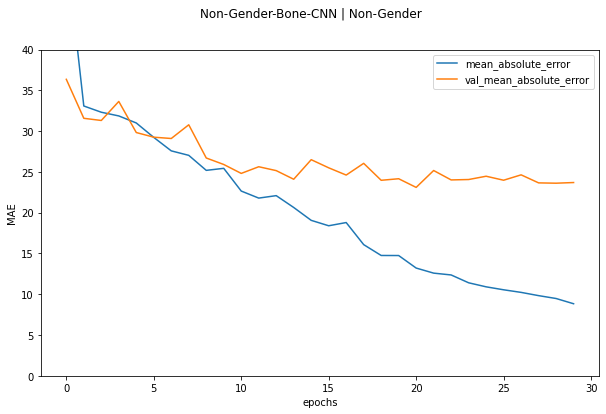

In [ ]:
plot_hist(df_hist_bone_model, model_name, version, gender=False)

## Model 2: Non-Gender VGG19 (NG-VGG19)

In [ ]:
from tensorflow.keras.applications import VGG19

model_name = 'Non-Gender-VGG19'
version = 'VGG19-uf5-2048-2048'

vgg19_imagenet_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# freeze the VGG19 model
for layer in vgg19_imagenet_model.layers[:-5]:
    layer.trainable = False

# Flatten output layer of VGG19
flattened = tf.keras.layers.Flatten()(vgg19_imagenet_model.output)

# Fully connected layer 1
x = tf.keras.layers.Dense(2048, activation='relu')(flattened)
x = tf.keras.layers.Dense(2048, activation='relu')(x)

# Fully connected layer, output layer
out = tf.keras.layers.Dense(1, name="Output-Layer")(x)

vgg19_model = tf.keras.models.Model(inputs=vgg19_imagenet_model.input, outputs=out, name=model_name)
vgg19_model.compile(loss='mean_absolute_error', metrics=[MeanAbsoluteError()])

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
batch_size = 32
epochs = 30

train_size = len(X_train_pic)
steps_per_epoch = train_size // batch_size

val_size = len(X_val_pic)
validation_steps = val_size // batch_size

hist_vgg19 = vgg19_model.fit(
    ng_train_generator, 
    epochs=epochs, 
    validation_data=ng_validation_generator,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    callbacks=[CustomSaver(model_name)]
)

Epoch 1/30
125/125 [==============================] - 74s 455ms/step - loss: 650.4902 - mean_absolute_error: 650.4902 - val_loss: 77.0035 - val_mean_absolute_error: 77.0035
Epoch 2/30
125/125 [==============================] - 57s 455ms/step - loss: 46.5732 - mean_absolute_error: 46.5732 - val_loss: 37.0019 - val_mean_absolute_error: 37.0019
Epoch 3/30
125/125 [==============================] - 57s 454ms/step - loss: 33.4452 - mean_absolute_error: 33.4452 - val_loss: 23.5539 - val_mean_absolute_error: 23.5539
Epoch 4/30
125/125 [==============================] - 57s 454ms/step - loss: 27.5789 - mean_absolute_error: 27.5789 - val_loss: 32.9506 - val_mean_absolute_error: 32.9506
Epoch 5/30
125/125 [==============================] - 57s 455ms/step - loss: 24.9886 - mean_absolute_error: 24.9886 - val_loss: 66.5869 - val_mean_absolute_error: 66.5869
Epoch 6/30
125/125 [==============================] - 57s 457ms/step - loss: 23.7889 - mean_absolute_error: 23.7889 - val_loss: 30.4572 - val_m

In [ ]:
test_size = len(X_test_pic)
test_steps = test_size // batch_size

vgg19_model.evaluate(ng_test_generator, steps=test_steps)

15/15 [==============================] - 5s 330ms/step - loss: 17.7171 - mean_absolute_error: 17.7171


[17.717092514038086, 17.717092514038086]

In [ ]:
vgg19_model, df_hist_vgg19 = save(vgg19_model, model_name, version, hist_vgg19, epoch=epochs, current_epoch=0)

History: VGG19-uf5-2048-2048_Non-Gender-VGG19 Saved!
Model: VGG19-uf5-2048-2048_Non-Gender-VGG19_30_epochs Saved!


          loss   val_loss  mean_absolute_error  val_mean_absolute_error
0   650.490173  77.003471           650.490173                77.003471
1    46.573250  37.001869            46.573250                37.001869
2    33.445198  23.553913            33.445198                23.553913
3    27.578936  32.950550            27.578936                32.950550
4    24.988562  66.586945            24.988562                66.586945
5    23.788908  30.457237            23.788908                30.457237
6    22.027536  16.950680            22.027536                16.950680
7    20.752985  26.287519            20.752985                26.287519
8    19.777889  16.177734            19.777889                16.177734
9    18.703703  16.991789            18.703703                16.991789
10   17.447800  17.346489            17.447800                17.346489
11   17.105991  15.413465            17.105991                15.413465
12   16.060228  15.607025            16.060228                15

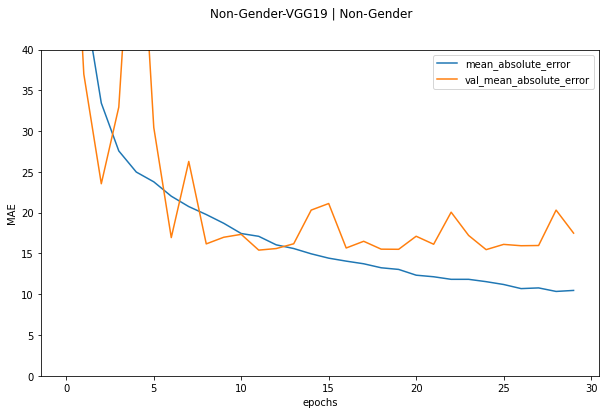

In [ ]:
plot_hist(df_hist_vgg19, model_name, version, gender=False)

# 2nd Scenario: Model with Gender

## Gender Generator

In [ ]:
def get_X_y(df):
  X_pic, X_gender = [], []
  y = []
  
  for data in df['NPZ_Path']:
    loaded_npz = np.load(data)

    pic = loaded_npz['pic']
    gender = loaded_npz['gender']
    boneage = loaded_npz['boneage']

    X_pic.append(pic)
    X_gender.append(gender)
    y.append(boneage)
  
  X_pic, X_gender = np.array(X_pic), np.array(X_gender)
  y = np.array(y)

  return X_pic, X_gender, y

In [ ]:
gen = ImageDataGenerator(
    rescale=1.0/255,
    # zoom_range=0.3,
    # brightness_range=[0.8, 1.2],
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # rotation_range=30,
)

# X1 is an image, y is the target, X2 is a numpy array - other data input        
def gen_flow_for_two_inputs(image, gender, boneage, batch_size=32):
    genX1 = gen.flow(image, boneage,  batch_size=batch_size, seed=666)
    genX2 = gen.flow(image, gender, batch_size=batch_size, seed=666)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        #Assert arrasy are equal - this was for peace of mind, but slows down training
        #np.testing.assert_array_equal(X1i[0],X2i[0])
        yield [X1i[0], X2i[1]], X1i[1]

In [ ]:
X_train_pic, X_train_gender, y_train = get_X_y(df_train_npz)

(X_train_pic.shape, X_train_gender.shape), y_train.shape

(((4000, 224, 224, 3), (4000,)), (4000,))

In [ ]:
X_val_pic, X_val_gender, y_val = get_X_y(df_val_npz)

(X_val_pic.shape, X_val_gender.shape), y_val.shape

(((500, 224, 224, 3), (500,)), (500,))

In [ ]:
X_test_pic, X_test_gender, y_test = get_X_y(df_test_npz)

(X_test_pic.shape, X_test_gender.shape), y_test.shape

(((500, 224, 224, 3), (500,)), (500,))

In [ ]:
g_train_generator = gen_flow_for_two_inputs(X_train_pic, X_train_gender, y_train)
g_validation_generator = gen_flow_for_two_inputs(X_val_pic, X_val_gender, y_val)
g_test_generator = gen_flow_for_two_inputs(X_test_pic, X_test_gender, y_test)

## Model 3: Gender Bone-CNN (G-B)

In [ ]:
model_name = 'Gender-Bone-CNN'
version = '32-64-128-256-512-2048-2048-G-64-64'

input_cnn = layers.Input(shape=(224, 224, 3), name='input_cnn')
x = layers.Conv2D(32, (3, 3), activation="relu")(input_cnn)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
output_cnn = layers.MaxPooling2D((2, 2), name='output_cnn')(x)

gender_bone_cnn = keras.Model(inputs=input_cnn, outputs=output_cnn, name='bone-cnn')

In [ ]:
feature_img = gender_bone_cnn.get_layer(name='output_cnn').output
feature_img = layers.Flatten()(feature_img)

input_gender = layers.Input(shape=(1,), name='INPUT_GENDER')
feature_gender = layers.Dense(64, activation='relu', name='feature-layer-1')(input_gender)
feature_gender = layers.Dense(64, activation='relu', name='feature-layer-2')(feature_gender)

feature = layers.concatenate([feature_img, feature_gender])

fc = layers.Dense(2048, activation='relu')(feature)
fc = layers.Dense(2048, activation='relu')(fc)
final_output = layers.Dense(1, name='FINAL_OUTPUT')(fc)

gender_bone_model = Model(inputs=[input_cnn, input_gender], outputs=final_output, name=model_name)

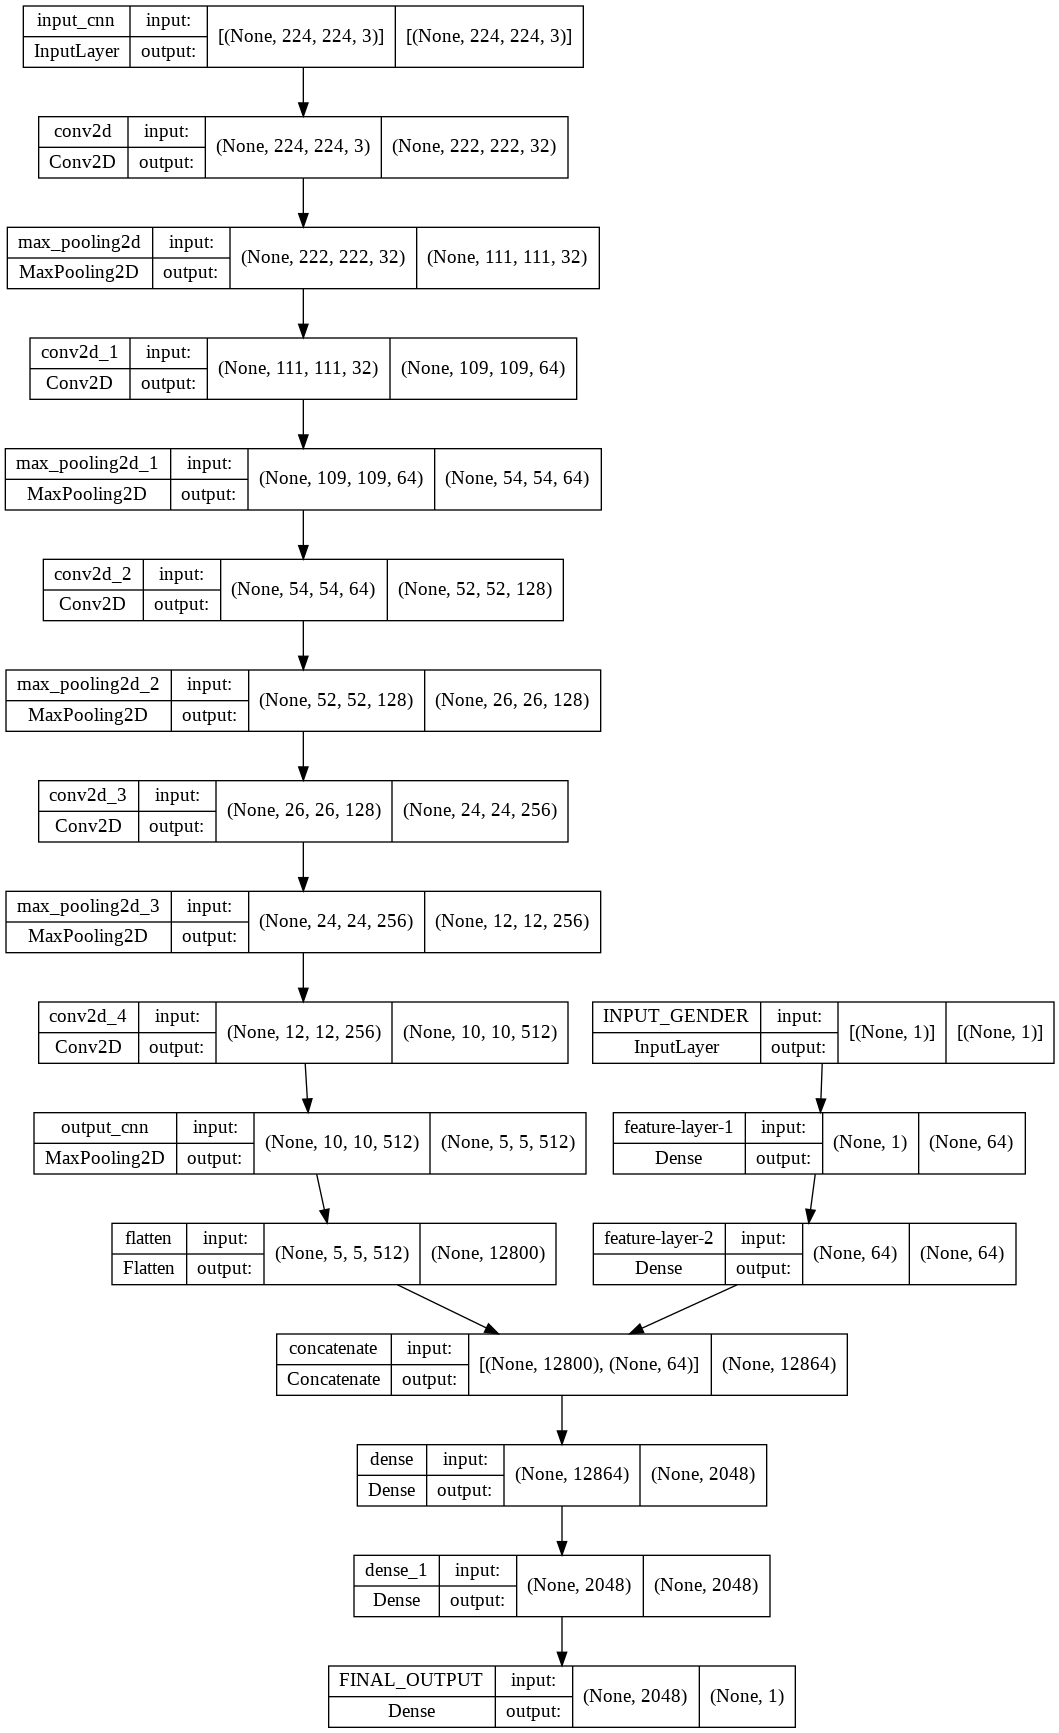

In [ ]:
tf.keras.utils.plot_model(
    gender_bone_model, 
    to_file='gender_bone_model.png', 
    show_shapes=True, 
    show_layer_names=True
)

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
gender_bone_model.compile(loss='mean_absolute_error', metrics=[MeanAbsoluteError()], optimizer = adam)

In [ ]:
batch_size = 32
epochs = 30

train_size = len(X_train_pic)
steps_per_epoch = train_size // batch_size

val_size = len(X_val_pic)
validation_steps = val_size // batch_size

hist_gender_bone_model = gender_bone_model.fit(
    g_train_generator,
    epochs = epochs, 
    validation_data = g_validation_generator,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    callbacks = [CustomSaver(model_name)],
)

Epoch 1/30
125/125 [==============================] - 30s 146ms/step - loss: 43.8527 - mean_absolute_error: 43.8527 - val_loss: 31.6372 - val_mean_absolute_error: 31.6372
Epoch 2/30
125/125 [==============================] - 17s 139ms/step - loss: 32.8112 - mean_absolute_error: 32.8112 - val_loss: 30.3778 - val_mean_absolute_error: 30.3778
Epoch 3/30
125/125 [==============================] - 17s 139ms/step - loss: 31.2950 - mean_absolute_error: 31.2950 - val_loss: 30.8416 - val_mean_absolute_error: 30.8416
Epoch 4/30
125/125 [==============================] - 17s 139ms/step - loss: 30.7073 - mean_absolute_error: 30.7073 - val_loss: 30.9393 - val_mean_absolute_error: 30.9393
Epoch 5/30
125/125 [==============================] - 17s 140ms/step - loss: 29.3668 - mean_absolute_error: 29.3668 - val_loss: 34.4200 - val_mean_absolute_error: 34.4200
Epoch 6/30
125/125 [==============================] - 17s 139ms/step - loss: 28.4827 - mean_absolute_error: 28.4827 - val_loss: 30.5186 - val_mea

In [ ]:
test_size = len(X_test_pic)
test_steps = test_size // batch_size

gender_bone_model.evaluate(g_test_generator, steps=test_steps)

15/15 [==============================] - 1s 60ms/step - loss: 19.2405 - mean_absolute_error: 19.2405


[19.240495681762695, 19.240495681762695]

In [ ]:
gender_bone_model, df_hist_gender_bone_model = save(gender_bone_model, model_name, version, hist_gender_bone_model, epoch=epochs, current_epoch=0)

History: 32-64-128-256-512-2048-2048-G-64-64_Gender-Bone-CNN Saved!
Model: 32-64-128-256-512-2048-2048-G-64-64_Gender-Bone-CNN_30_epochs Saved!


         loss   val_loss  mean_absolute_error  val_mean_absolute_error
0   43.852722  31.637157            43.852722                31.637157
1   32.811226  30.377850            32.811226                30.377850
2   31.294985  30.841581            31.294985                30.841581
3   30.707317  30.939260            30.707317                30.939260
4   29.366823  34.420036            29.366823                34.420036
5   28.482718  30.518593            28.482718                30.518593
6   25.605267  24.118319            25.605267                24.118319
7   24.485712  23.510782            24.485712                23.510782
8   22.531628  22.580322            22.531628                22.580322
9   22.017530  26.692629            22.017530                26.692629
10  20.556364  22.807991            20.556364                22.807991
11  18.663422  22.777555            18.663422                22.777555
12  17.005552  21.451532            17.005552                21.451532
13  17

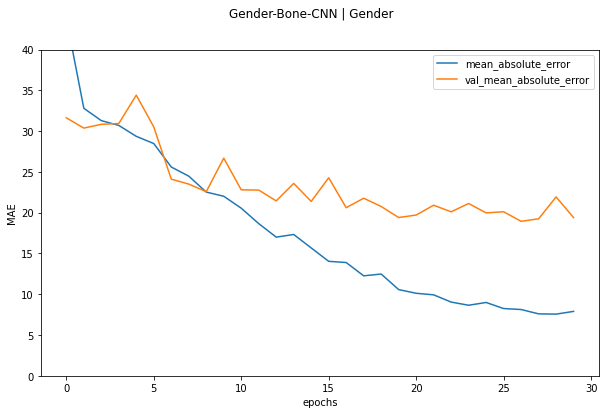

In [ ]:
plot_hist(df_hist_gender_bone_model, model_name, version, gender=True)

## Model 4: Gender VGG19 (G-VGG19)

In [ ]:
from tensorflow.keras.applications import VGG19

model_name = 'Gender-VGG19'
version = 'VGG19-uf5-2048-2048-G-64-64'

bone_vgg19_imagenet_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# freeze the VGG19 model
for layer in bone_vgg19_imagenet_model.layers[:-5]:
    layer.trainable = False

In [ ]:
# Flatten VGG19 output layers
feature_img = bone_vgg19_imagenet_model.output
feature_img = layers.Flatten()(feature_img)

# Gender FC layers
input_gender = layers.Input(shape=(1,), name='Input-Gender')
feature_gender = layers.Dense(64, activation='relu', name='feature-layer-1')(input_gender)
feature_gender = layers.Dense(64, activation='relu', name='feature-layer-2')(feature_gender)

feature = layers.concatenate([feature_img, feature_gender])

# Fully connected layer 1
x = tf.keras.layers.Dense(2048, activation='relu')(feature)
x = tf.keras.layers.Dense(2048, activation='relu')(x)

# Fully connected layer, output layer
out = tf.keras.layers.Dense(1, name="Output-Layer")(x)

gender_vgg19_model = tf.keras.models.Model(inputs=[bone_vgg19_imagenet_model.input, input_gender], outputs=out, name=model_name)
gender_vgg19_model.compile(loss='mean_absolute_error', metrics=[MeanAbsoluteError()])

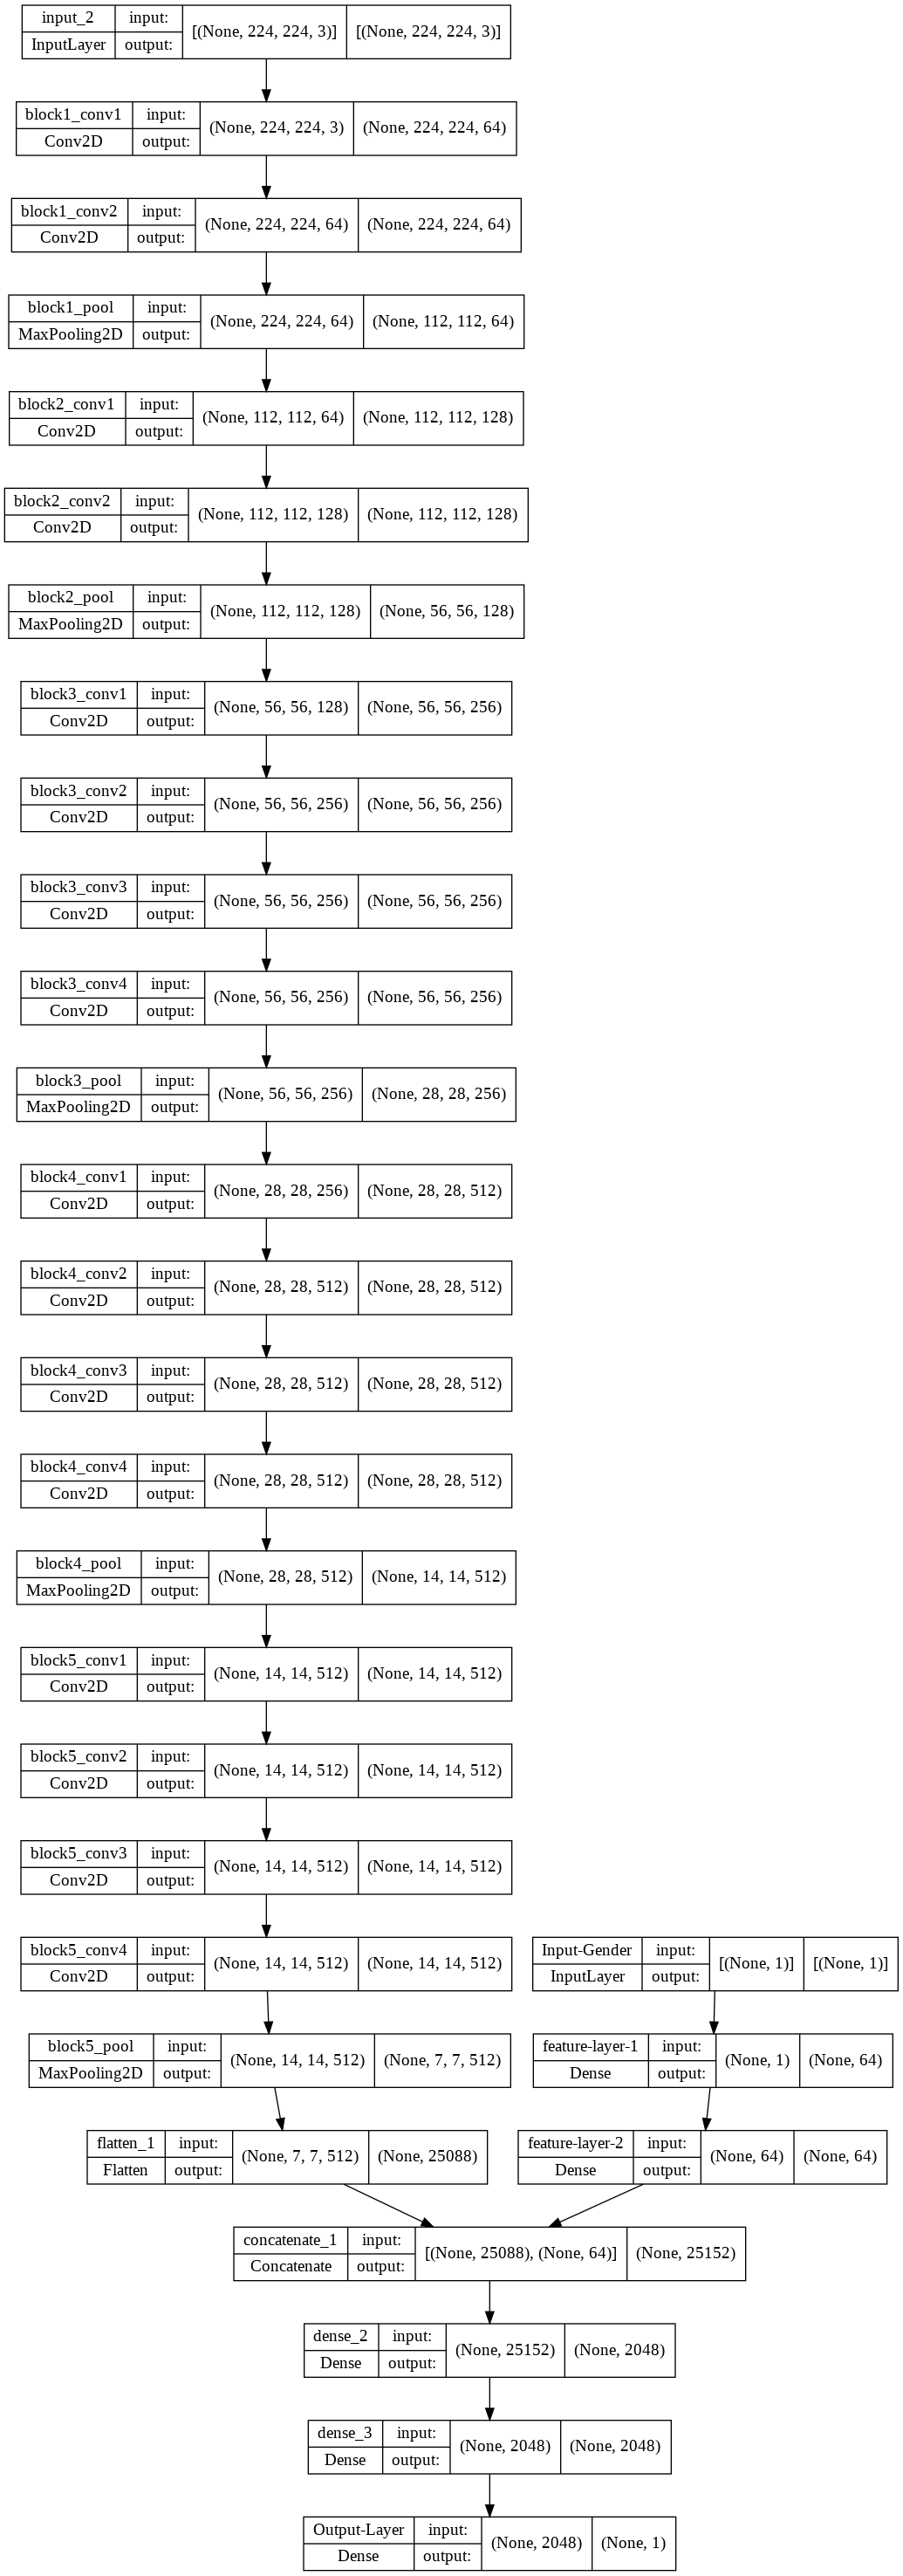

In [ ]:
tf.keras.utils.plot_model(
    gender_vgg19_model, 
    to_file='gender_vgg19_model.png', 
    show_shapes=True, 
    show_layer_names=True
)

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
gender_vgg19_model.compile(loss='mean_absolute_error', metrics=[MeanAbsoluteError()], optimizer = adam)

In [ ]:
batch_size = 32
epochs = 30

train_size = len(X_train_pic)
steps_per_epoch = train_size // batch_size

val_size = len(X_val_pic)
validation_steps = val_size // batch_size

hist_gender_vgg19_model = gender_vgg19_model.fit(
    g_train_generator,
    epochs = epochs, 
    validation_data = g_validation_generator,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    callbacks = [CustomSaver(model_name)],
)

Epoch 1/30
125/125 [==============================] - 60s 438ms/step - loss: 32.4207 - mean_absolute_error: 32.4207 - val_loss: 21.3729 - val_mean_absolute_error: 21.3729
Epoch 2/30
125/125 [==============================] - 54s 436ms/step - loss: 19.1928 - mean_absolute_error: 19.1928 - val_loss: 16.3035 - val_mean_absolute_error: 16.3035
Epoch 3/30
125/125 [==============================] - 54s 436ms/step - loss: 15.6318 - mean_absolute_error: 15.6318 - val_loss: 14.0780 - val_mean_absolute_error: 14.0780
Epoch 4/30
125/125 [==============================] - 54s 436ms/step - loss: 16.1198 - mean_absolute_error: 16.1198 - val_loss: 15.6700 - val_mean_absolute_error: 15.6700
Epoch 5/30
125/125 [==============================] - 54s 436ms/step - loss: 14.1749 - mean_absolute_error: 14.1749 - val_loss: 15.7244 - val_mean_absolute_error: 15.7244
Epoch 6/30
125/125 [==============================] - 54s 436ms/step - loss: 14.1418 - mean_absolute_error: 14.1418 - val_loss: 13.6229 - val_mea

In [ ]:
test_size = len(X_test_pic)
test_steps = test_size // batch_size

gender_vgg19_model.evaluate(g_test_generator, steps=test_steps)

15/15 [==============================] - 5s 331ms/step - loss: 11.7292 - mean_absolute_error: 11.7292


[11.729156494140625, 11.729156494140625]

In [ ]:
gender_vgg19_model, df_hist_gender_vgg19_model = save(gender_vgg19_model, model_name, version, hist_gender_vgg19_model, epoch=epochs, current_epoch=0)

History: VGG19-uf5-2048-2048-G-64-64_Gender-VGG19 Saved!
Model: VGG19-uf5-2048-2048-G-64-64_Gender-VGG19_30_epochs Saved!


         loss   val_loss  mean_absolute_error  val_mean_absolute_error
0   32.420689  21.372936            32.420689                21.372936
1   19.192783  16.303455            19.192783                16.303455
2   15.631824  14.077985            15.631824                14.077985
3   16.119761  15.669962            16.119761                15.669962
4   14.174865  15.724370            14.174865                15.724370
5   14.141780  13.622927            14.141780                13.622927
6   13.312438  16.418808            13.312438                16.418808
7   12.161799  20.823164            12.161799                20.823164
8   11.975227  17.633999            11.975227                17.633999
9   11.010522  11.878732            11.010522                11.878732
10  10.158309  12.335465            10.158309                12.335465
11  10.126588  11.483194            10.126588                11.483194
12   9.873841  11.717159             9.873841                11.717159
13   9

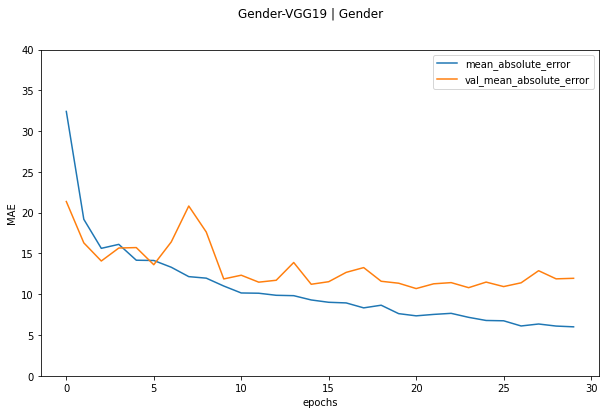

In [ ]:
plot_hist(df_hist_gender_vgg19_model, model_name, version, gender=True)

# Results

## MAE Movement Plot Comparison

In [ ]:
hist_ng_b = pd.read_csv('drive/MyDrive/Bone-Age-Regression/hist_32-64-128-256-512-2048-2048_Non-Gender-Bone-CNN_30_model.csv')
hist_ng_vgg19 = pd.read_csv('drive/MyDrive/Bone-Age-Regression/hist_VGG19-uf5-2048-2048_Non-Gender-VGG19_30_model.csv')
hist_g_b = pd.read_csv('drive/MyDrive/Bone-Age-Regression/hist_32-64-128-256-512-2048-2048-G-64-64_Gender-Bone-CNN_30_model.csv')
hist_g_vgg19 = pd.read_csv('drive/MyDrive/Bone-Age-Regression/hist_VGG19-uf5-2048-2048-G-64-64_Gender-VGG19_30_model.csv')

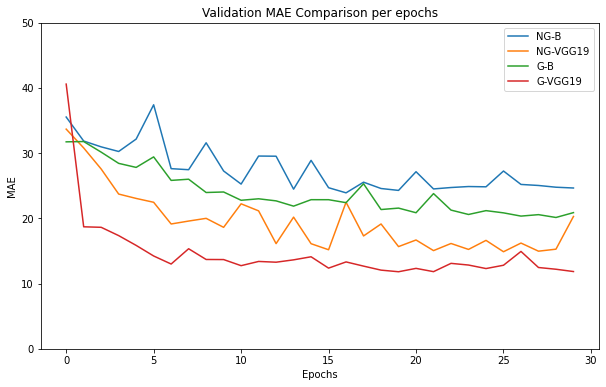

In [ ]:
plt.figure(figsize=(10, 6))

hist_ng_b['val_mean_absolute_error'][:].plot()
hist_ng_vgg19['val_mean_absolute_error'][:].plot()
hist_g_b['val_mean_absolute_error'][:].plot()
hist_g_vgg19['val_mean_absolute_error'][:].plot()

plt.legend(['NG-B', 'NG-VGG19', 'G-B', 'G-VGG19'])
plt.gca().set_ylim([0, 50])

plt.title(f"Validation MAE Comparison per epochs")
plt.xlabel("Epochs")
plt.ylabel("MAE")

plt.savefig(f'drive/MyDrive/Bone-Age-Regression/plot_hist_comparison')
plt.show()

## Accuracy Comparison

In [ ]:
ng_b_model = load_model('drive/MyDrive/Bone-Age-Regression/32-64-128-256-512-2048-2048_Non-Gender-Bone-CNN_30_epochs.h5', compile=False)
ng_vgg19_model = load_model('drive/MyDrive/Bone-Age-Regression/VGG19-uf5-2048-2048_Non-Gender-VGG19_30_epochs.h5', compile=False)
g_b_model = load_model('drive/MyDrive/Bone-Age-Regression/32-64-128-256-512-2048-2048-G-64-64_Gender-Bone-CNN_30_epochs.h5', compile=False)
g_vgg19_model = load_model('drive/MyDrive/Bone-Age-Regression/VGG19-uf5-2048-2048-G-64-64_Gender-VGG19_30_epochs.h5', compile=False)

adam = tf.keras.optimizers.Adam(learning_rate=0.001)
ng_b_model.compile(loss='mean_absolute_error', metrics=[MeanAbsoluteError()], optimizer = adam)
ng_vgg19_model.compile(loss='mean_absolute_error', metrics=[MeanAbsoluteError()], optimizer = adam)
g_b_model.compile(loss='mean_absolute_error', metrics=[MeanAbsoluteError()], optimizer = adam)
g_vgg19_model.compile(loss='mean_absolute_error', metrics=[MeanAbsoluteError()], optimizer = adam)

In [ ]:
print("Non-Gender Bone Model Evaluation")
ng_b_accuracy = ng_b_model.evaluate(ng_test_generator)
print("Non-Gender VGG19 Model Evaluation")
ng_vgg19_accuracy = ng_vgg19_model.evaluate(ng_test_generator)

test_size = len(X_test_pic)
test_steps = test_size // batch_size

print("Gender Bone Model Evaluation")
g_b_accuracy = g_b_model.evaluate(g_test_generator, steps=test_steps)
print("Gender VGG19 Model Evaluation")
g_vgg19_accuracy = g_vgg19_model.evaluate(g_test_generator, steps=test_steps)

Non-Gender Bone Model Evaluation
16/16 [==============================] - 23s 1s/step - loss: 18.3443 - mean_absolute_error: 18.4766
Non-Gender VGG19 Model Evaluation
16/16 [==============================] - 22s 1s/step - loss: 16.9267 - mean_absolute_error: 16.9471
Gender Bone Model Evaluation
15/15 [==============================] - 1s 64ms/step - loss: 19.2400 - mean_absolute_error: 19.2400
Gender VGG19 Model Evaluation
15/15 [==============================] - 6s 342ms/step - loss: 11.4675 - mean_absolute_error: 11.4675


In [ ]:
print("Mean Absolute Error of Each Model")
print("Non-Gender Bone Model:", ng_b_accuracy[1])
print("Non-Gender VGG19 Model:", ng_vgg19_accuracy[1])
print("Gender Bone Model:", g_b_accuracy[1])
print("Gender VGG19 Model:", g_vgg19_accuracy[1])

Mean Absolute Error of Each Model
Non-Gender Bone Model: 18.47660255432129
Non-Gender VGG19 Model: 16.947099685668945
Gender Bone Model: 19.240032196044922
Gender VGG19 Model: 11.467487335205078
